In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
pd.set_option('display.max_rows', None)

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# According to EDA, these were the columns important for price prediction
price_prediction_columns = [
    'sector',
    'num_bedrooms',
    'num_bathrooms',
    'num_balconies',
    'age_group', 
    'super_built_up_area', 
    'built_up_area', 
    'carpet_area',
    'floor_number',
    'servant_room',
    'pooja_room',
    'store_room',
    'furnished',
    'Centrally Air Conditioned',
    'False Ceiling Lighting',
    'Intercom Facility',
    'Private Garden / Terrace',
    'Separate entry for servant room',
    'Spacious Interiors'
]

In [16]:
data = pd.read_csv("data_cleaned_v3.csv")

# Getting rid of columns which won't be available while prediction(to avoid data leakage) or columns whose cleaner version is already available

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 84 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            2838 non-null   float64
 1   facing                           2038 non-null   object 
 2   property_id                      2838 non-null   object 
 3   sector                           2838 non-null   object 
 4   society_name                     2838 non-null   object 
 5   society_stars                    1631 non-null   float64
 6   num_bedrooms                     2838 non-null   int64  
 7   num_bathrooms                    2838 non-null   float64
 8   num_balconies                    2838 non-null   float64
 9   age_group                        2838 non-null   object 
 10  super_built_up_area              2838 non-null   float64
 11  built_up_area                    2838 non-null   float64
 12  carpet_area         

In [18]:
columns_to_drop = [
    'property_id', # user won't give as input
    'facing', # has NaN value, also EDA said not at all important for price prediction
    'nearby_locations', # NLP required currently can't do anything
    'description_keywords', # NLP required, currently can't do anything
    'society_name', # user won't give as input
    'society_stars', # user won't give as input
    'price_per_sqft', # user won't give as input
    'amenities_rating', # user won't give as input
    'connectivity_rating', # user won't give as input
    'construction_rating', # user won't give as input
    'environment_rating', # user won't give as input
    'green area_rating', # user won't give as input
    'lifestyle_rating', # user won't give as input
    'management_rating', # user won't give as input
    'safety_rating', # user won't give as input
    'total_floors' # user won't tell
]

In [19]:
data.drop(columns=columns_to_drop, inplace=True)

In [20]:
data.columns

Index(['price', 'sector', 'num_bedrooms', 'num_bathrooms', 'num_balconies',
       'age_group', 'super_built_up_area', 'built_up_area', 'carpet_area',
       'floor_number', 'servant_room', 'study_room', 'pooja_room',
       'other_additional_room', 'store_room', 'ac', 'bed', 'chimney',
       'curtains', 'dining', 'exhaust', 'fan', 'fridge', 'geyser', 'light',
       'microwave', 'modular', 'sofa', 'stove', 'tv', 'wardrobe', 'washing',
       'water', 'Airy Rooms', 'Bank Attached Property',
       'Centrally Air Conditioned', 'Club house / Community Center',
       'False Ceiling Lighting', 'Feng Shui / Vaastu Compliant',
       'Fitness Centre / GYM', 'High Ceiling Height', 'Intercom Facility',
       'Internet/wi-fi connectivity', 'Lift(s)', 'Low Density Society',
       'Maintenance Staff', 'Natural Light', 'No open drainage around', 'Park',
       'Piped-gas', 'Power Back-up', 'Private Garden / Terrace',
       'Rain Water Harvesting', 'Recently Renovated', 'Security / Fire Alarm'

# Tree Based Feature Selection(Ordinal Encoding would work well)

In [21]:
import copy

original_data = copy.deepcopy(data) # storing a copy of data

In [22]:
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = data.select_dtypes(include=['object']).columns
for column_name in categorical_columns:
    data[column_name] = OrdinalEncoder().fit_transform(data[[column_name]])

In [23]:
data.sample(5)

,price,sector,num_bedrooms,num_bathrooms,num_balconies,age_group,super_built_up_area,built_up_area,carpet_area,floor_number,...,Spacious Interiors,Swimming Pool,Visitor Parking,Waste Disposal,Water Storage,Water purifier,Water softening plant,total_num_rooms,furnished,floor_category
1628,0.98,19.0,2,3.0,3.0,0.0,1041.777072,978.230000,734.430000,12.0,...,0,1,0,0,0,0,0,12.0,1,2.0
1612,1.82,57.0,3,3.0,4.0,1.0,1836.000000,1830.000000,1500.000000,14.0,...,1,1,1,1,1,1,1,11.0,1,2.0
2039,0.45,104.0,2,2.0,1.0,2.0,689.769000,599.896670,531.000000,10.0,...,0,0,0,0,0,0,0,5.0,0,2.0
187,0.36,77.0,2,2.0,1.0,0.0,808.266667,700.000000,620.914464,0.0,...,0,0,0,0,0,0,0,5.0,0,1.0
2710,0.45,101.0,2,2.0,2.0,2.0,667.686000,580.690939,514.000000,14.0,...,0,0,0,0,0,0,0,6.0,0,2.0


In [24]:
X = data.drop(columns=['price'])
y = data['price']

# Removing Duplicate Columns

In [25]:
def get_duplicate_columns(data):
    
    duplicate_columns = {}
    seen_columns = {}

    for column in data.columns:
        current_column = data[column]

        # Converting column data to bytes
        try:
            current_column_hash = current_column.values.tobytes()
        except AttributeError:
            current_column_hash = current_column.to_string().encode()

        if current_column_hash in seen_columns:
            if seen_columns[current_column_hash] in duplicate_columns:
                duplicate_columns[seen_columns[current_column_hash]].append(column)
            else:
                duplicate_columns[seen_columns[current_column_hash]] = [column]
        else:
            seen_columns[current_column_hash] = column

    return duplicate_columns

In [26]:
get_duplicate_columns(X)

{}

There isn't any duplicate columns

# Variance Threshold

In [27]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.01)
vt.fit(X)

VarianceThreshold(threshold=0.01)

In [28]:
sum(vt.get_support())

67

All the columns have variance greater than threshold

# Pearson Correlation Coefficient

**Note: All these shows the extent to which these columns are 'linearly' related to output, and not overall relation.**

- super_built_up_area > built_up_area > carpet_area, so can keep only super_built_up_area
- num_bathrooms(0.59) > total_num_rooms(0.58) > num_bedrooms(0.50+) > servant_room(0.40+) > num_balconies(0.30+)
- ac(0.4) > geyser(0.31) > wardrobe(0.25) > fan(0.25) > chimney(0.24) > stove(0.23) > light(0.22) > furnished(0.21)
- floor_number(0.21) >>> floor_category(~0)
- Separate entry for servant room(0.23) >  Intercom Facility(0.19) > Swimming Pool(0.17) > False Ceiling Lighting(0.16) > Piped-gas(0.15) > Spacious Interiors(0.15) > High Ceiling Height(0.15) > Centrally Air Conditioned(0.15) > Club house / Community Center(0.15) > Low Density Society(0.15) > No open drainage around(0.14) > Private Garden / Terrace(0.14)

<Axes: >

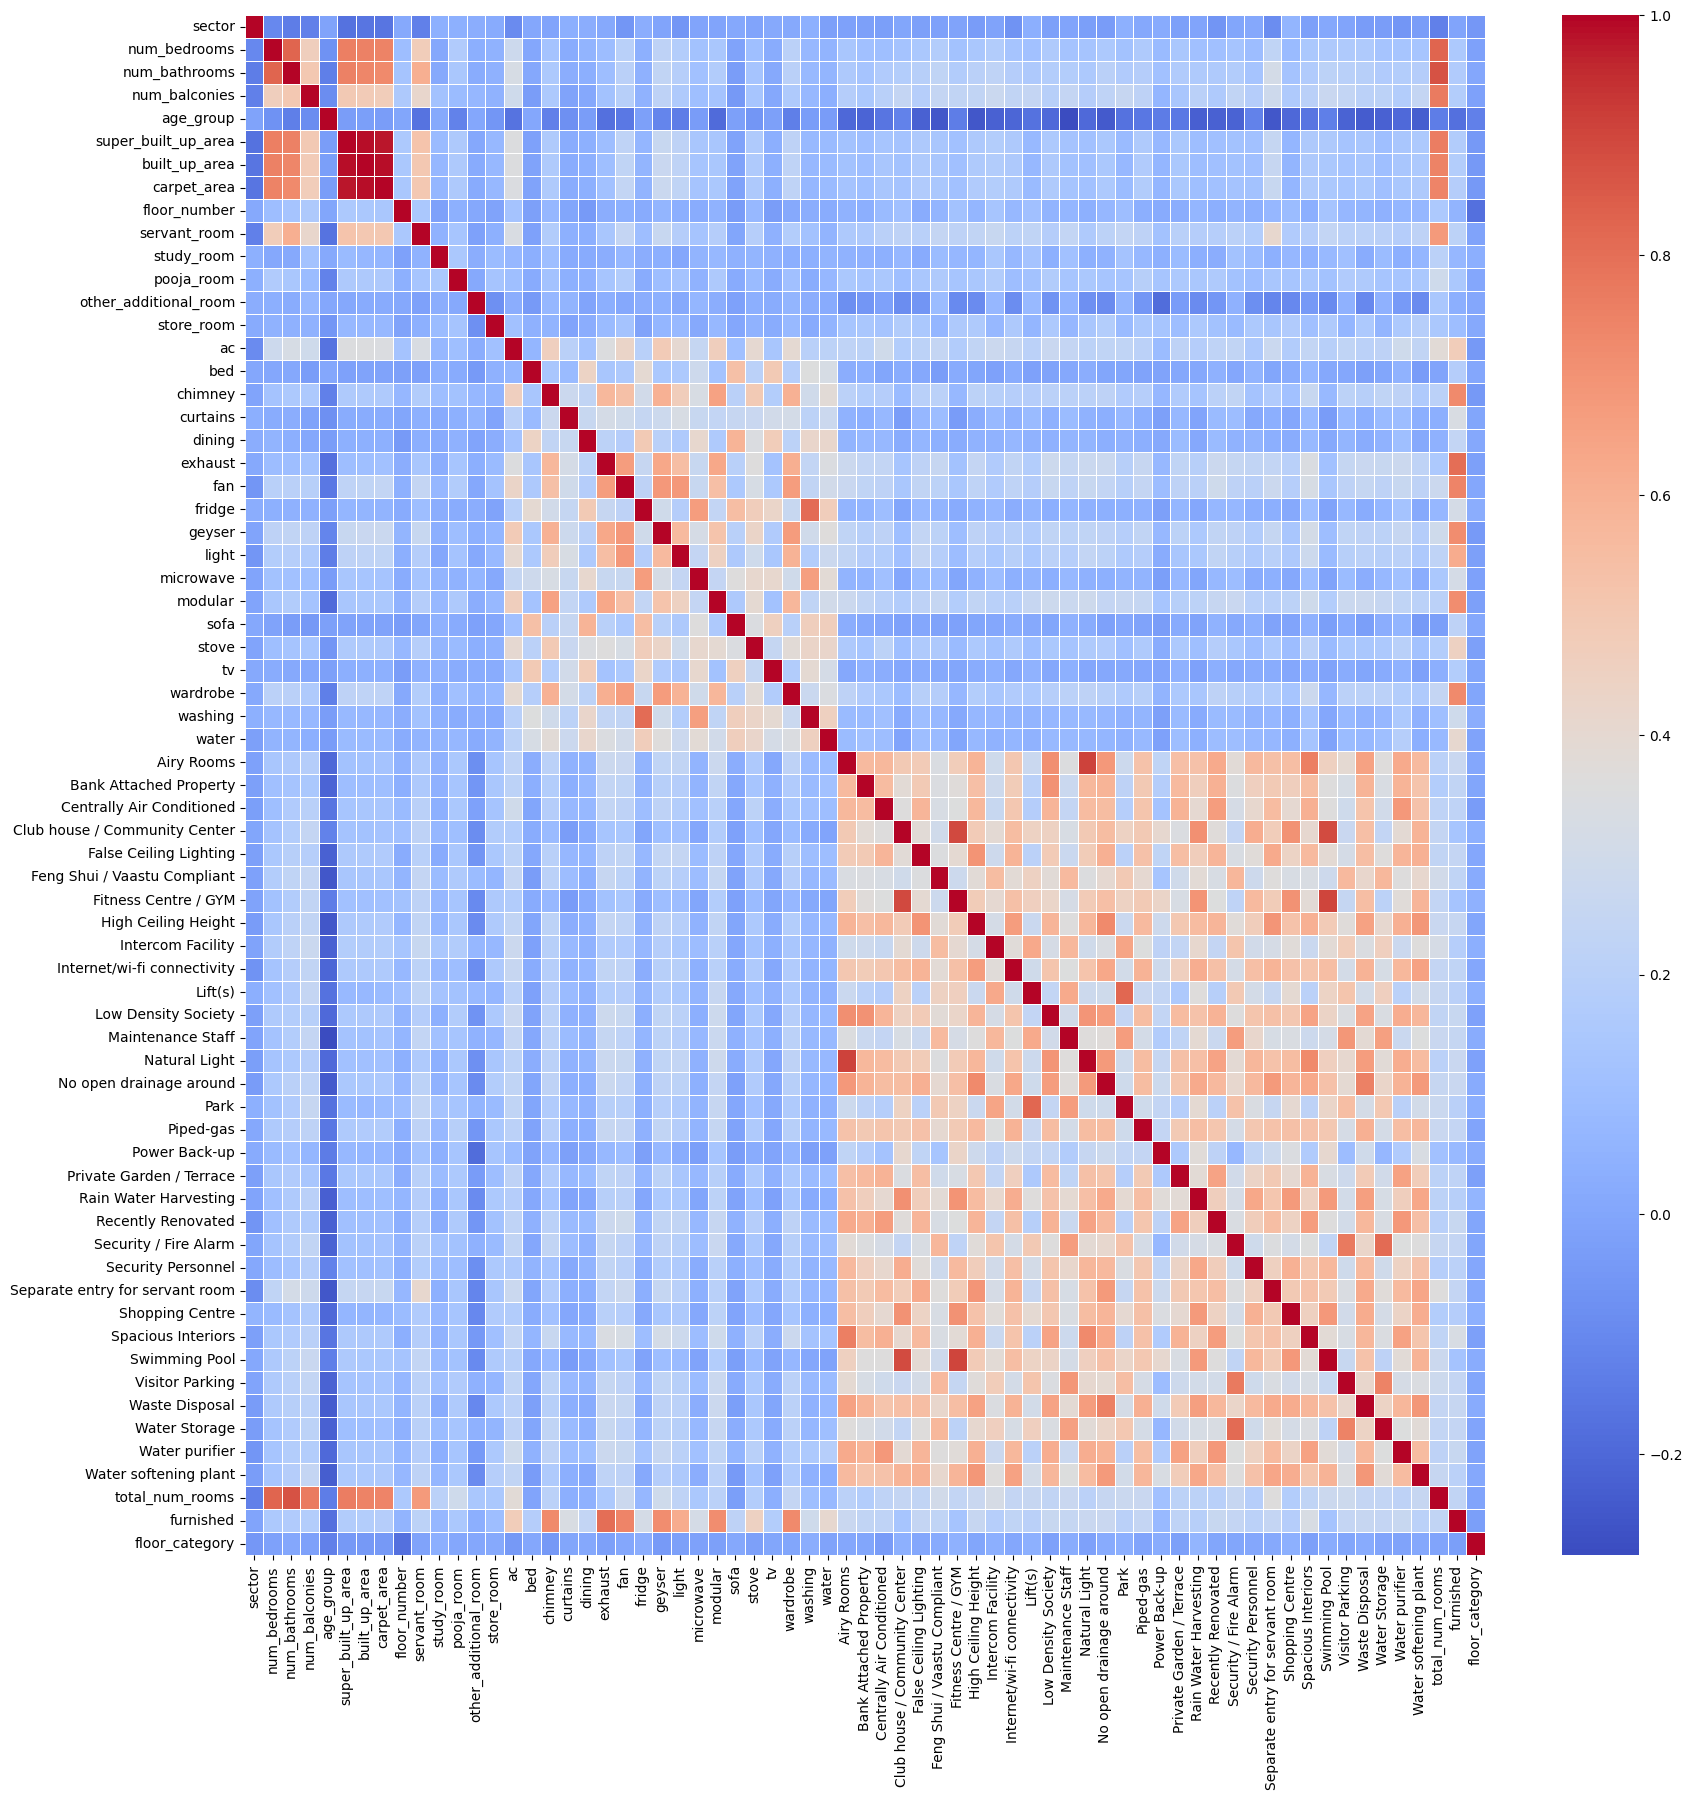

In [29]:
plt.figure(figsize=(20, 20))

sns.heatmap(X.corr(), cmap='coolwarm', linewidths=.5)

- super_built_up_area, built_up_area and carpet_area have a strong positive correlation

In [30]:
data.corr()['num_bedrooms']['num_bathrooms']

0.8261361111927917

In [31]:
data.corr()['super_built_up_area']['num_bedrooms']

0.7587276938847876

In [32]:
# So the minimum correlation present in data(dark violet colored heatmap) is nearly -0.21.
data.corr()['age_group']['Airy Rooms']

-0.20357310884343222

In [33]:
data.corr()['washing']['fridge']

0.8051297182084614

In [34]:
corr_coef_price = data.corr()['price'].reset_index().rename(columns={'index': 'feature', 'price': 'correlation_coefficient'})

In [35]:
correlation_data = corr_coef_price.set_index('feature').squeeze().drop('price')

In [36]:
correlation_data

feature
sector                            -0.184608
num_bedrooms                       0.568605
num_bathrooms                      0.601927
num_balconies                      0.382372
age_group                          0.047586
super_built_up_area                0.784877
built_up_area                      0.784402
carpet_area                        0.767257
floor_number                       0.221398
servant_room                       0.454334
study_room                         0.067561
pooja_room                         0.105472
other_additional_room              0.003011
store_room                         0.062297
ac                                 0.403953
bed                               -0.011892
chimney                            0.246562
curtains                           0.052848
dining                             0.041414
exhaust                            0.139681
fan                                0.255330
fridge                             0.124782
geyser                  

In [37]:
corr_coef_price.sort_values('correlation_coefficient', ascending=False).T.to_dict()

{0: {'feature': 'price', 'correlation_coefficient': 1.0},
 6: {'feature': 'super_built_up_area',
  'correlation_coefficient': 0.7848774211737103},
 7: {'feature': 'built_up_area',
  'correlation_coefficient': 0.7844018956798959},
 8: {'feature': 'carpet_area', 'correlation_coefficient': 0.7672566329245302},
 3: {'feature': 'num_bathrooms',
  'correlation_coefficient': 0.6019274144443855},
 65: {'feature': 'total_num_rooms',
  'correlation_coefficient': 0.5990536058898867},
 2: {'feature': 'num_bedrooms', 'correlation_coefficient': 0.5686050945716702},
 10: {'feature': 'servant_room',
  'correlation_coefficient': 0.45433415650436176},
 15: {'feature': 'ac', 'correlation_coefficient': 0.4039530177713033},
 4: {'feature': 'num_balconies',
  'correlation_coefficient': 0.38237204753222026},
 23: {'feature': 'geyser', 'correlation_coefficient': 0.3505450726354165},
 21: {'feature': 'fan', 'correlation_coefficient': 0.25533014842491303},
 30: {'feature': 'wardrobe', 'correlation_coefficient':

# Mutual Information

- Unlike correlation coefficient, it can even capture non linear relationship.
- super_built_up_area(0.89) >> built_up_area/carpet(0.72).
- sector(0.61) is the next most important column.
- total_num_rooms(0.43) > num_bathrooms(0.39) > num_bedrooms(0.32) > num_balconies(0.21) 
- ac(0.17) > wardrobe(0.12) > fan(0.11) > geyser(0.11)
- servant_room(0.16) > > pooja_room(0.03) > study_room(0.02), store_room and other_additional_room are 0.
- Swimming Pool(0.07) > Separate entry for servant room(0.07) > Club house / Community Center(0.06) > Water softening plant(0.06) > Water softening plant(0.05) > Water purifier(0.05) > Fitness Centre / GYM(0.05) > Feng Shui / Vaastu Compliant(0.05) > High Ceiling Height(0.05) > Maintenance Staff(0.05).
- floor_number(0.06) > floor_category(0.03) 

In [38]:
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X, y)
mutual_information_values = {}

for feature_name, mutual_info_value in zip(X.columns, mutual_info):
    mutual_information_values[feature_name] = mutual_info_value

In [39]:
mutual_information_values = dict(sorted(mutual_information_values.items(), key=lambda item: item[1], reverse=True))

In [40]:
mutual_information_values

{'super_built_up_area': 0.8824274142797792,
 'built_up_area': 0.740041147816834,
 'carpet_area': 0.7130216837687087,
 'sector': 0.6015320211146511,
 'total_num_rooms': 0.4088297894869557,
 'num_bathrooms': 0.3874485880564009,
 'num_bedrooms': 0.31805670118561347,
 'num_balconies': 0.20265798382470424,
 'ac': 0.17150083251411674,
 'servant_room': 0.15877499306444554,
 'wardrobe': 0.12939921216085892,
 'geyser': 0.11839973023452544,
 'fan': 0.09436816367591838,
 'light': 0.07405704800078139,
 'Separate entry for servant room': 0.07133365962183014,
 'Swimming Pool': 0.06377726653068638,
 'chimney': 0.05716077499736194,
 'Intercom Facility': 0.056323810259580664,
 'False Ceiling Lighting': 0.05380395898038204,
 'floor_number': 0.053520130752684913,
 'Water softening plant': 0.051403129079584886,
 'Club house / Community Center': 0.05131221428923283,
 'No open drainage around': 0.04872776944414037,
 'stove': 0.045383072044022255,
 'Centrally Air Conditioned': 0.04419131428039558,
 'Water St

In [41]:
mutual_info_data = pd.Series(mutual_information_values)
mutual_info_data

super_built_up_area                0.882427
built_up_area                      0.740041
carpet_area                        0.713022
sector                             0.601532
total_num_rooms                    0.408830
num_bathrooms                      0.387449
num_bedrooms                       0.318057
num_balconies                      0.202658
ac                                 0.171501
servant_room                       0.158775
wardrobe                           0.129399
geyser                             0.118400
fan                                0.094368
light                              0.074057
Separate entry for servant room    0.071334
Swimming Pool                      0.063777
chimney                            0.057161
Intercom Facility                  0.056324
False Ceiling Lighting             0.053804
floor_number                       0.053520
Water softening plant              0.051403
Club house / Community Center      0.051312
No open drainage around         

# Sequential Forward Selection

- Clearly from above, we can see that very less features are important for price prediction, so we choose forward and not backward.
- 'sector', 'num_balconies', 'super_built_up_area', 'servant_room', 'pooja_room', 'store_room', 'bed', 'Bank Attached Property', 'Centrally Air Conditioned', 'Lift(s)', 'Low Density Society', 'Natural Light', 'Private Garden / Terrace', 'Rain Water Harvesting', 'Spacious Interiors' are the 15 most important features according to Decision Tree.

In [42]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(random_state=42)
sfs = SequentialFeatureSelector(reg, k_features=15, forward=True, floating=False, scoring='neg_mean_squared_error', cv=5)
sfs.fit(X, y)
selected_features = list(X.columns[list(sfs.k_feature_idx_)])

In [43]:
selected_features

['sector',
 'num_bedrooms',
 'num_bathrooms',
 'super_built_up_area',
 'study_room',
 'bed',
 'exhaust',
 'sofa',
 'tv',
 'Bank Attached Property',
 'Intercom Facility',
 'Park',
 'Recently Renovated',
 'Water Storage',
 'furnished']

# Random Forest Feature Importance

- super_built_up_area(0.47) >> sector(0.13), rest are quite low.

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

In [45]:
random_forest_data = feature_importance_rf.set_index('feature').squeeze()

In [46]:
random_forest_data

feature
super_built_up_area                0.392460
built_up_area                      0.269215
sector                             0.145256
floor_number                       0.024669
geyser                             0.019942
carpet_area                        0.019843
num_bathrooms                      0.012612
total_num_rooms                    0.011093
age_group                          0.008705
ac                                 0.007547
light                              0.007016
num_balconies                      0.006172
servant_room                       0.004976
wardrobe                           0.004970
num_bedrooms                       0.004929
fan                                0.004867
microwave                          0.003641
study_room                         0.002795
Security / Fire Alarm              0.002549
floor_category                     0.002407
stove                              0.001910
Lift(s)                            0.001849
Park                    

# Gradient Boosting Feature importances

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X, y)

feature_importance_gb = pd.DataFrame({
    'feature': X.columns,
    'gb_importance': gb.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

In [48]:
gradient_boosting_data = feature_importance_gb.set_index('feature').squeeze()

In [49]:
gradient_boosting_data

feature
super_built_up_area                4.768728e-01
built_up_area                      2.098990e-01
sector                             1.735644e-01
num_bathrooms                      3.133287e-02
geyser                             1.912950e-02
ac                                 1.813943e-02
floor_number                       1.541449e-02
carpet_area                        1.195637e-02
age_group                          5.445426e-03
total_num_rooms                    4.154044e-03
floor_category                     3.428477e-03
servant_room                       3.406962e-03
microwave                          2.833667e-03
light                              2.374577e-03
Intercom Facility                  2.042884e-03
study_room                         1.991810e-03
curtains                           1.656024e-03
fan                                1.463036e-03
Swimming Pool                      1.388551e-03
num_balconies                      1.295827e-03
Security Personnel              

# Permutation Importance

In [50]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
perm_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

In [51]:
permutation_importance_data = perm_feature_importance.set_index('feature').squeeze()

In [52]:
permutation_importance_data

feature
super_built_up_area                5.742969e-01
sector                             2.415663e-01
built_up_area                      8.784460e-02
floor_number                       8.362565e-03
geyser                             8.345002e-03
ac                                 5.977265e-03
carpet_area                        5.911079e-03
num_bedrooms                       4.062523e-03
servant_room                       3.952022e-03
total_num_rooms                    3.888417e-03
num_bathrooms                      2.952153e-03
age_group                          2.667789e-03
Security / Fire Alarm              2.199109e-03
Park                               1.373401e-03
Maintenance Staff                  1.307322e-03
num_balconies                      1.275222e-03
light                              1.230594e-03
Intercom Facility                  1.208284e-03
microwave                          1.201756e-03
water                              9.834874e-04
Visitor Parking                 

# Recursive Feature Elimination

In [53]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X.shape[1], step=1)
selector_label = selector_label.fit(X, y)

# Get the selected features based on RFE
selected_features = X.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
rfe = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

In [54]:
recursive_feature_elimination_data = rfe.set_index('feature').squeeze()

In [55]:
recursive_feature_elimination_data

feature
super_built_up_area                0.465505
built_up_area                      0.206609
sector                             0.143201
floor_number                       0.023433
geyser                             0.020219
carpet_area                        0.017020
total_num_rooms                    0.010856
num_bathrooms                      0.008746
age_group                          0.008399
light                              0.006863
ac                                 0.006402
num_balconies                      0.006141
wardrobe                           0.005691
num_bedrooms                       0.005423
fan                                0.005046
servant_room                       0.004813
microwave                          0.003721
study_room                         0.002680
floor_category                     0.002663
curtains                           0.002556
stove                              0.002001
Lift(s)                            0.001954
Security / Fire Alarm   

# SHAP

In [56]:
# import shap

# # Compute SHAP values using the trained Random Forest model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X, y)

# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X)

# # Summing the absolute SHAP values across all samples to get an overall measure of feature importance
# shap_sum = np.abs(shap_values).mean(axis=0)
# shap_score = pd.DataFrame({
#     'feature': X.columns,
#     'SHAP_score': np.abs(shap_values).mean(axis=0)
# }).sort_values(by='SHAP_score', ascending=False)

In [57]:
# shap_data = shap_score.set_index('feature').squeeze()

In [58]:
overall_ordinal_encoding_importance = correlation_data.apply(abs) + mutual_info_data.apply(abs) + random_forest_data.apply(abs) + gradient_boosting_data.apply(abs) + permutation_importance_data.apply(abs) + recursive_feature_elimination_data.apply(abs)

In [59]:
overall_ordinal_encoding_importance.sort_values(ascending=False)

super_built_up_area                3.576439
built_up_area                      2.298011
carpet_area                        1.535009
sector                             1.489728
num_bathrooms                      1.045020
total_num_rooms                    1.037874
num_bedrooms                       0.901487
servant_room                       0.630257
ac                                 0.613520
num_balconies                      0.599914
geyser                             0.536580
wardrobe                           0.397841
fan                                0.361190
floor_number                       0.346797
light                              0.323308
Separate entry for servant room    0.313597
chimney                            0.306172
stove                              0.303705
furnished                          0.262606
Intercom Facility                  0.259425
microwave                          0.252023
Swimming Pool                      0.234606
modular                         

# Encoding wrt Linear Models(One Hot Encoding)

In [60]:
data = copy.deepcopy(original_data)

In [61]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = data.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['sector', 'age_group', 'floor_category'], dtype='object')


So, all of them can be one hot encoded, as all are nominal features

In [62]:
for column_name in categorical_columns:
    one_hot_encoded = pd.get_dummies(data[column_name], prefix=column_name, drop_first=True)
    
    data = data.drop(column_name, axis=1)

    data = pd.concat([data, one_hot_encoded], axis=1)

In [63]:
X = data.drop('price', axis=1)
y = data['price']

In [64]:
data.columns

Index(['price', 'num_bedrooms', 'num_bathrooms', 'num_balconies',
       'super_built_up_area', 'built_up_area', 'carpet_area', 'floor_number',
       'servant_room', 'study_room',
       ...
       'sector_sector 95', 'sector_sector 99', 'sector_shanti nagar',
       'sector_sohna road', 'age_group_Moderately Old Flat',
       'age_group_New Flat', 'age_group_Old Flat',
       'age_group_Under Construction', 'floor_category_Low rise',
       'floor_category_Mid rise'],
      dtype='object', length=175)

In [65]:
# dropping too high correlated input columns(since, inference would not be good due to multicollinearity)
def get_highly_correlated_columns(X, correlation_threshold=0.9):
    correlation_pairs = []

    for i in range(len(X.columns)):
        for j in range(i + 1, len(X.columns)):
            col1 = X.columns[i]
            col2 = X.columns[j]

            # Calculate the correlation between the two columns
            correlation = X[col1].corr(X[col2])

            # Check if the correlation is greater than the threshold
            if abs(correlation) > correlation_threshold:
                correlation_pairs.append((col1, col2, correlation))
    return correlation_pairs

In [66]:
correlation_pairs = get_highly_correlated_columns(X)

In [67]:
correlation_pairs

[('super_built_up_area', 'built_up_area', 0.9895821928017687),
 ('super_built_up_area', 'carpet_area', 0.9773784926890435),
 ('built_up_area', 'carpet_area', 0.9891446716486114),
 ('Airy Rooms', 'Natural Light', 0.9073024492143167),
 ('Fitness Centre / GYM', 'Swimming Pool', 0.9041177713925223)]

In [68]:
 # dropping the columns from the pairs which had lower scores in tree based Feature selection
X.drop(columns=['built_up_area', 'carpet_area', 'Natural Light', 'Fitness Centre / GYM'], inplace=True)

# Lasso

- Whether your house is in the costly sectors/not varies price a lot.
- Hence linear model suggests super_built_up_area, sector, ac, num_bathrooms, floor_number.

In [69]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y)

# Extract coefficients
lasso = pd.DataFrame({
    'feature': X.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

In [70]:
lasso_scores = lasso.set_index('feature').squeeze().sort_values(ascending=False)

In [71]:
lasso_scores

feature
super_built_up_area                0.719897
sector_sector 53                   0.202470
sector_sector 65                   0.197708
sector_sector 43                   0.139352
sector_sector 63                   0.113606
sector_sector 54                   0.111570
sector_sector 62                   0.104673
sector_sector 66                   0.096273
sector_sector 59                   0.096124
sector_sector 72                   0.093324
sector_sector 28                   0.089095
floor_number                       0.087148
sector_sector 67                   0.079207
sector_sector 22                   0.076050
sector_sector 61                   0.072660
sector_sector 112                  0.066566
num_bathrooms                      0.062479
ac                                 0.059277
sector_sector 58                   0.059126
sector_sector 24                   0.058874
sector_sector 60                   0.058749
sector_sector 113                  0.057218
sector_sector 50        

# Linear Regression Weights

In [72]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y)

# Extract coefficients
linear_regression_scores = pd.DataFrame({
    'feature': X.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

In [73]:
linear_regression_scores = linear_regression_scores.set_index('feature').squeeze().sort_values(ascending=False)

In [74]:
linear_regression_scores # doesn't seem trustable

feature
num_balconies                      1.071652e+11
num_bathrooms                      1.010379e+11
num_bedrooms                       7.669292e+10
servant_room                       4.692699e+10
study_room                         3.659997e+10
pooja_room                         3.257506e+10
other_additional_room              3.040020e+10
store_room                         2.229042e+10
super_built_up_area                7.016220e-01
sector_sector 53                   1.685257e-01
sector_sector 43                   9.713554e-02
sector_sector 65                   8.172035e-02
sector_sector 54                   7.357836e-02
sector_sector 62                   6.877804e-02
sector_sector 59                   6.501055e-02
fridge                             5.709839e-02
ac                                 5.592728e-02
sector_sector 63                   5.543518e-02
floor_number                       5.343628e-02
sector_sector 24                   4.912567e-02
Centrally Air Conditioned       

In [75]:
overall_ordinal_encoding_importance.sort_values(ascending=False)

super_built_up_area                3.576439
built_up_area                      2.298011
carpet_area                        1.535009
sector                             1.489728
num_bathrooms                      1.045020
total_num_rooms                    1.037874
num_bedrooms                       0.901487
servant_room                       0.630257
ac                                 0.613520
num_balconies                      0.599914
geyser                             0.536580
wardrobe                           0.397841
fan                                0.361190
floor_number                       0.346797
light                              0.323308
Separate entry for servant room    0.313597
chimney                            0.306172
stove                              0.303705
furnished                          0.262606
Intercom Facility                  0.259425
microwave                          0.252023
Swimming Pool                      0.234606
modular                         

# Final Decision

In [76]:
important_columns = [
    'sector',
    'num_bedrooms',
    'num_bathrooms',
    'num_balconies',
    'age_group', 
    'super_built_up_area', 
    'floor_number',
    'servant_room',
    'furnished',
    'Centrally Air Conditioned',
    'False Ceiling Lighting',
    'Intercom Facility',
    'Private Garden / Terrace',
    'Separate entry for servant room',
    'Spacious Interiors',
    'Swimming Pool',
    'Club house / Community Center',
    'Piped-gas',
    'ac',
    'geyser',
    'fan',
    'wardrobe',
    'light',
    'Low Density Society',
    'total_num_rooms',
]

# Initial Model

In [89]:
price_prediction_data = original_data[important_columns]

In [100]:
X = price_prediction_data
y = original_data['price']

In [101]:
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = X.select_dtypes(include=['object']).columns
for column_name in categorical_columns:
    X[column_name] = OrdinalEncoder().fit_transform(X[[column_name]])

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

scores = cross_val_score(gb, X, y, cv=5, scoring='r2')

In [103]:
scores.mean()

0.803249394940124

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_regressor.fit(X_train, y_train.ravel())

# Make predictions on the test set
y_pred = gb_regressor.predict(X_test)

# Calculate Mean Absolute Error on the test set
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.3244894578887919


In [105]:
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_regressor = XGBRegressor()

# Train the model on the training set
xgb_regressor.fit(X_train, np.log1p(y_train))

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)
mae = mean_absolute_error(y_test, np.expm1(y_pred))

print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.2690794925391674


In [106]:
from sklearn.metrics import r2_score
r2_score(y_test, np.expm1(y_pred))

0.8414585651435248

In [114]:
price_prediction_data['price'] = original_data['price']

In [115]:
price_prediction_data.to_csv('flat_price_prediction_data.csv', index=False)